In [53]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
from scipy.stats import zscore


In [3]:
# Load the physiological data from the Oura Ring
oura_data = pd.read_csv("../Studies/oura_feats_bin01_23.csv")
# Load the MBSS score data
mbss_data = pd.read_csv("../Studies/mbss_scores.csv")

In [13]:
# Calculate the change in MBSS scores for each participant
mbss_pivot = mbss_data.pivot(index='ID', columns='Time Point', values=['EE Total Score', 'DP Total Score', 'PA Total Score'])
mbss_changes = mbss_pivot.xs('Follow Up', level='Time Point', axis=1) + mbss_pivot.xs('Baseline', level='Time Point', axis=1)
# mbss_changes = mbss_pivot.xs('Baseline', level='Time Point', axis=1)

# Calculate the mean of the physiological features across the time series for each participant
oura_summary = oura_data.groupby('participant_id').mean()

# Merge the MBSS changes with the physiological summary data
merged_data = pd.merge(mbss_changes, oura_summary, left_index=True, right_on='participant_id')

# Clean the data by removing NaNs
cleaned_merged_data = merged_data.replace([np.inf, -np.inf], np.nan).dropna()

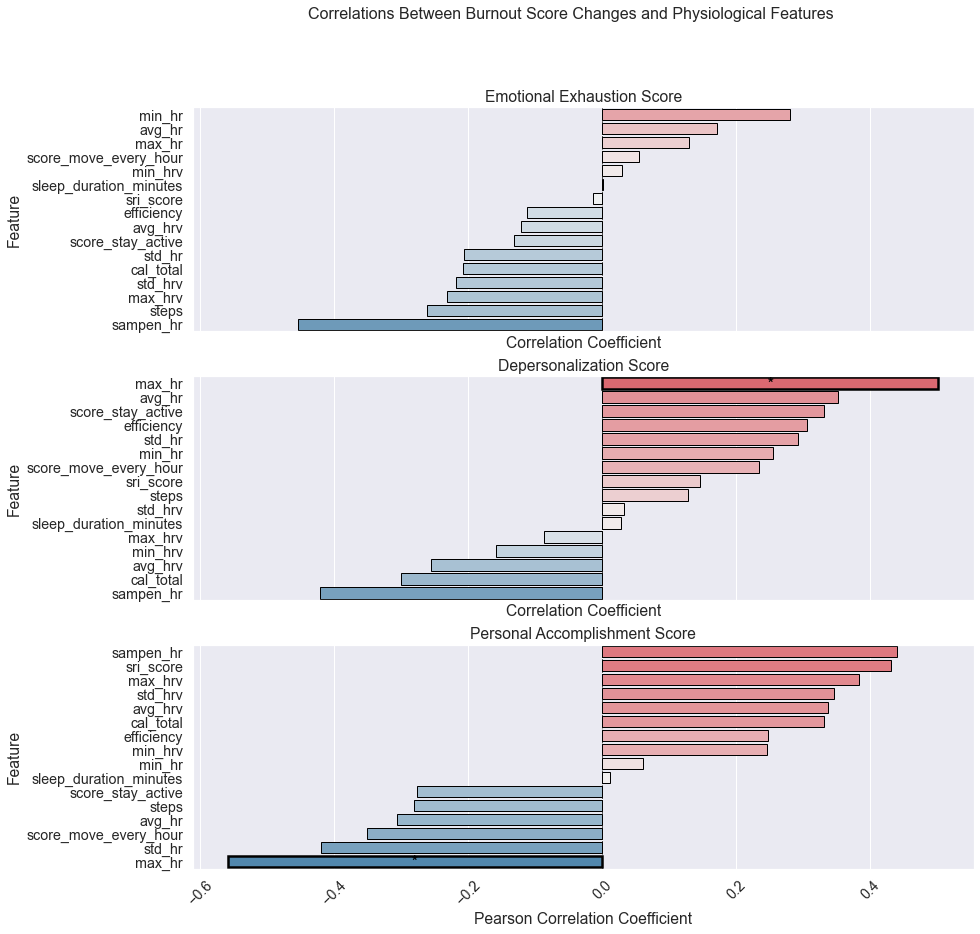

In [38]:
score_change_dict = {"EE": "Emotional Exhaustion", "DP": "Depersonalization", "PA": "Personal Accomplishment"}

# Perform the correlation analysis
correlation_results = {}
for score_type in ['EE Total Score', 'DP Total Score', 'PA Total Score']:
    correlation_results[score_type] = {}
    for feature in oura_summary.columns:
        corr_coefficient, p_value = stats.pearsonr(cleaned_merged_data[score_type], cleaned_merged_data[feature])
        correlation_results[score_type][feature] = (corr_coefficient, p_value)

# Prepare the data for visualization
correlation_data = []
for score_change, features in correlation_results.items():
    for feature, (corr_coefficient, p_value) in features.items():
        correlation_data.append({
            'Score Change': score_change.replace(' Total Score', ''),
            'Feature': feature,
            'Correlation Coefficient': corr_coefficient,
            'P-value': p_value
        })

# Convert to a DataFrame for visualization
full_correlation_df = pd.DataFrame(correlation_data)

# Set up the matplotlib figure with subplots for EE, DP, and PA
fig, axes = plt.subplots(3, 1, figsize=(14, 14), sharex=True)
fig.suptitle('Correlations Between Burnout Score Changes and Physiological Features', fontsize=16)

# Plot for each score change category
for i, score_change in enumerate(['EE', 'DP', 'PA']):
    # Filter the DataFrame for the specific score change
    df_filtered = full_correlation_df[full_correlation_df['Score Change'].str.contains(score_change)]
    df_sorted = df_filtered.sort_values(by='Correlation Coefficient', ascending=False)
    
    # Define the center for your colormap
    center = 0

    # Find the range of your correlation coefficients and set the limits for your colormap
    vmin = full_correlation_df['Correlation Coefficient'].min()
    vmax = full_correlation_df['Correlation Coefficient'].max()
    vmax = max(abs(vmin), abs(vmax))  # Ensure that the colormap is symmetrical

    # Create a diverging colormap
    cmap = sns.diverging_palette(240, 10, s=80, l=55, n=200, center="light", as_cmap=True)

    # Create a normalization object that centers the colormap
    norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)
    
    # Normalize the correlation coefficients and map to the colormap
    colors = [cmap(norm(x)) for x in df_sorted['Correlation Coefficient']]
    sns.set(font_scale = 1.3)
    # Create barplot with the custom colors
    barplot = sns.barplot(
        x='Correlation Coefficient', 
        y='Feature', 
        data=df_sorted, 
        ax=axes[i], 
        palette=colors,  # Use the mapped colors here
        edgecolor='black'
    )
    
    # Annotate bars with significant p-values
    for p, bar in zip(df_sorted["P-value"], barplot.patches):
        if p < 0.05:
            bar.set_edgecolor('black')
            bar.set_linewidth(2.5)
            axes[i].text(
                bar.get_x() + bar.get_width() / 2, 
                bar.get_y() + bar.get_height() / 2, 
                "*", 
                ha='center', 
                va='center', 
                color='black', 
                fontsize=15, 
                weight='bold'
            )

    axes[i].set_title(f'{score_change_dict[score_change]} Score')
    axes[i].axvline(0, color='black', linewidth=0.7, linestyle='--')

# Set common labels
plt.xlabel('Pearson Correlation Coefficient')
# plt.subplot_tool()
plt.xticks(rotation=45)
# plt.subplots_adjust(hspace=0.4)

# Show the plot
plt.show()

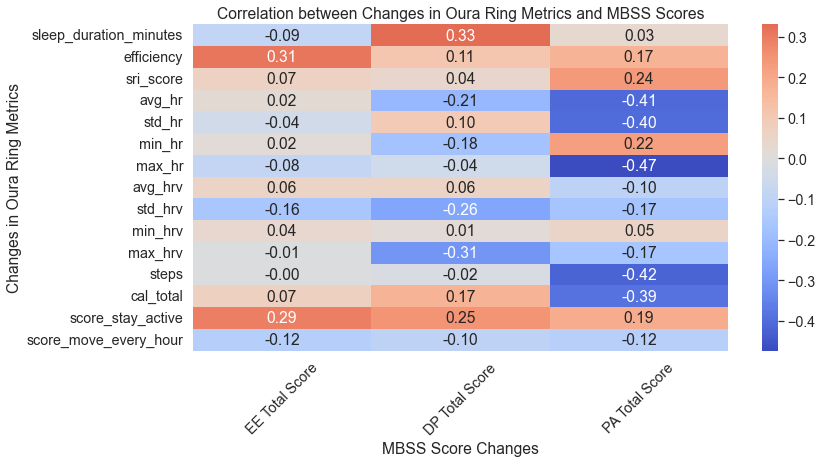

In [66]:
# Reload the Oura Ring data and preprocess it
oura_data = pd.read_csv("../Studies/oura_feats_bin01_23.csv")
# Replace Inf values with NaN to handle them together
oura_data.replace([float('inf'), -float('inf')], pd.NA, inplace=True)

# Replace NaN values with the mean of each column
oura_data.fillna(oura_data.mean(numeric_only=True), inplace=True)

# Convert the 'date' column into ordinal numbers (number of days) for regression
oura_data['date'] = pd.to_datetime(oura_data['date'])
oura_data['date_ordinal'] = oura_data['date'].apply(lambda x: x.toordinal())

# Normalize the numeric features using z-score normalization
numeric_features = oura_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('date_ordinal')  # Remove 'date_ordinal' from the list of numeric features to normalize
oura_data[numeric_features] = oura_data[numeric_features].apply(stats.zscore)

# Re-calculate the slopes after normalization
feature_trends = {'participant_id': []}

for participant_id, group in oura_data.groupby('participant_id'):
    feature_trends['participant_id'].append(participant_id)
    for feature in numeric_features:
        # Skip the date ordinal feature
        if feature == 'date_ordinal':
            continue
        
        # Apply linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(group['date_ordinal'], group[feature])
        
        # Store the slope
        feature_trends.setdefault(feature, []).append(slope)

# Convert the dictionary to a DataFrame
trends_df = pd.DataFrame(feature_trends)

# Display the trends DataFrame
trends_df.head()

# Calculate the changes in MBSS scores from baseline to follow-up for each participant
mbss_baseline = mbss_data[mbss_data['Time Point'] == 'Baseline'].set_index('ID')
mbss_follow_up = mbss_data[mbss_data['Time Point'] == 'Follow Up'].set_index('ID')

# We assume that each participant has one baseline and one follow-up entry
mbss_score_changes = (mbss_follow_up[['EE Total Score', 'DP Total Score', 'PA Total Score']] - 
                      mbss_baseline[['EE Total Score', 'DP Total Score', 'PA Total Score']])

# Merge the overall trend in Oura features with the MBSS score changes
trend_correlation_data = trends_df.merge(mbss_score_changes, left_on="participant_id", right_index=True)

# Calculate the correlation between the trends in physiological features and the changes in MBSS scores
trend_correlation_matrix = trend_correlation_data.corr()

# Focus on the correlation between the overall trends in Oura Ring features and the MBSS score changes
trend_correlation_matrix.loc[numeric_columns, ['EE Total Score', 'DP Total Score', 'PA Total Score']]

plt.figure(figsize=(12, 6))
sns.heatmap(trend_correlation_matrix.loc[numeric_columns, ['EE Total Score', 'DP Total Score', 'PA Total Score']],
            annot=True, fmt=".2f", cmap='coolwarm', center=0)

# Add labels and title to the heatmap
plt.title('Correlation between Changes in Oura Ring Metrics and MBSS Scores')
plt.xlabel('MBSS Score Changes')
plt.ylabel('Changes in Oura Ring Metrics')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show the heatmap
plt.show()

In [ ]:
# Load rhythm features data
rhythm_7days = pd.read_csv('../Studies/BIN_features/rhythm_features/rhythm7daystemplate.csv')
rhythm_14days = pd.read_csv('../Studies/BIN_features/rhythm_features/rhythm14daystemplate.csv')
rhythm_21days = pd.read_csv('../Studies/BIN_features/rhythm_features/rhythm21daystemplate.csv')

# Add suffixes to column names
rhythm_7days = rhythm_7days.add_suffix('_7')
rhythm_14days = rhythm_14days.add_suffix('_14')
rhythm_21days = rhythm_21days.add_suffix('_21')

# Merge rhythm features with MBSS changes
merged_data = pd.merge(mbss_data, rhythm_7days, how='left', on='participant_id')
merged_data = pd.merge(merged_data, rhythm_14days, how='left', on='participant_id')
merged_data = pd.merge(merged_data, rhythm_21days, how='left', on='participant_id')

# Normalize rhythm features
numeric_features = merged_data.select_dtypes(include=[np.number]).columns.tolist()
merged_data[numeric_features] = merged_data[numeric_features].apply(zscore)

# Calculate correlation matrix
correlation_matrix = merged_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Rhythm Features and MBSS Score Changes')
plt.show()

In [65]:
trends_df

,participant_id,sleep_duration_minutes,efficiency,sri_score,avg_hr,std_hr,min_hr,max_hr,avg_hrv,std_hrv,min_hrv,max_hrv,steps,cal_total,score_stay_active,score_move_every_hour
0,BIN01,-0.054849,-0.008512,0.019543,-0.017804,-0.016437,0.007682,-0.022261,0.019412,0.021386,0.001578,0.022048,0.002689,-0.003982,0.022438,-0.019665
1,BIN02,0.004997,0.018841,0.045889,-0.036647,-0.062635,0.016739,-0.071724,-0.012422,-0.014098,-0.001343,-0.008316,-0.035230,-0.022253,0.020341,0.003690
2,BIN03,-0.004678,-0.000742,0.036872,0.000309,-0.007442,0.002387,-0.031156,-0.005903,-0.003585,-0.000723,-0.006489,-0.001091,-0.002056,0.008725,0.006048
3,BIN04,-0.020000,-0.006072,0.028618,0.003221,-0.026875,0.018029,-0.019232,0.001056,0.004560,0.000288,0.003408,-0.012090,-0.007530,0.016873,0.010749
4,BIN05,0.001754,-0.041525,0.022110,-0.014238,0.019560,-0.052323,-0.023421,0.004365,0.013548,-0.012615,0.011742,-0.013297,-0.007030,0.036157,0.001691
5,BIN06,-0.004009,0.017613,0.025110,0.002293,0.004862,0.004590,0.005990,0.015373,-0.010176,-0.000767,0.004145,-0.000835,0.003132,-0.017824,-0.029049
6,BIN07,-0.013271,0.043731,0.030372,0.001575,-0.010644,0.035082,-0.000071,0.006697,0.012345,0.000002,0.018066,0.003809,-0.000688,-0.010373,-0.014414
7,BIN08,-0.005007,0.006398,0.028187,-0.016248,-0.010577,0.004469,-0.020229,0.010051,-0.007847,0.012100,-0.003929,-0.005073,-0.004363,-0.007604,0.023124
8,BIN09,-0.003678,-0.023737,0.019411,0.005818,-0.033606,0.043640,0.006397,-0.033520,-0.027581,-0.002986,-0.029777,0.021746,0.008198,0.009723,0.006730
9,BIN10,-0.000962,-0.005978,0.033012,-0.004036,-0.017834,0.007926,-0.015770,-0.003475,-0.011056,-0.000275,-0.009476,-0.033541,-0.012749,-0.029544,-0.008317


Text(0, 0.5, 'Number of participants')

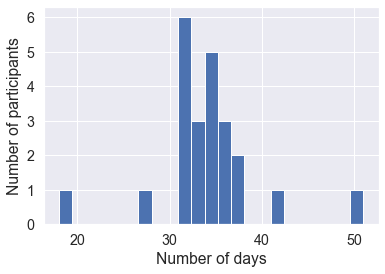

In [77]:
oura_data.groupby("participant_id").date.count().hist(bins=23)
plt.xlabel("Number of days")
plt.ylabel("Number of participants")

In [78]:
oura_data.groupby("participant_id").date.count()

participant_id
BIN01    32
BIN02    32
BIN03    34
BIN04    33
BIN05    18
BIN06    33
BIN07    31
BIN08    32
BIN09    36
BIN10    28
BIN11    42
BIN12    32
BIN13    32
BIN14    36
BIN15    37
BIN16    34
BIN17    37
BIN18    35
BIN19    51
BIN20    35
BIN21    36
BIN22    35
BIN23    33
Name: date, dtype: int64

In [103]:
# Load the physiological data from the Oura Ring
oura_data = pd.read_csv("../Studies/oura_feats_bin01_23.csv")
# Replace Inf values with NaN and then fill NaN values with the mean of the column
oura_data.replace([np.inf, -np.inf], np.nan, inplace=True)
oura_data.fillna(oura_data.mean(), inplace=True)
# Descriptive statistics for the overall dataset
overall_stats = oura_data.describe()

# Descriptive statistics for each participant
participant_stats = oura_data.groupby('participant_id').describe()

c:\Users\hello\anaconda3\envs\general_dl\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


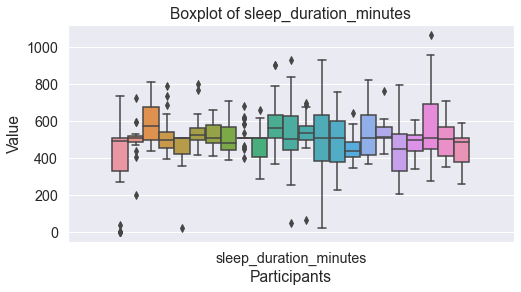

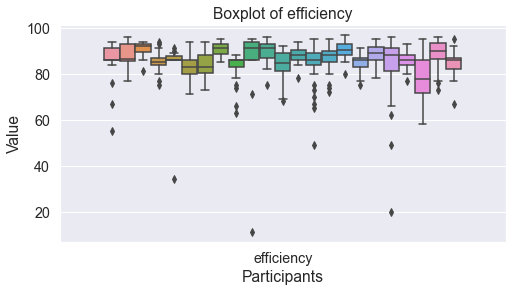

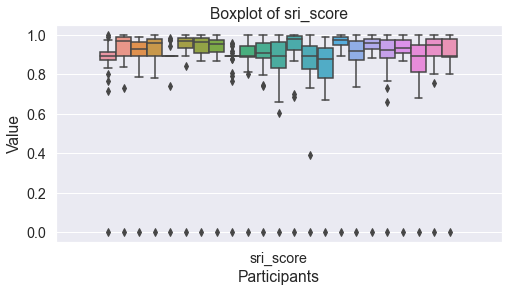

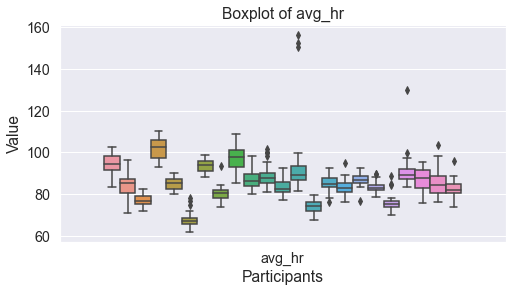

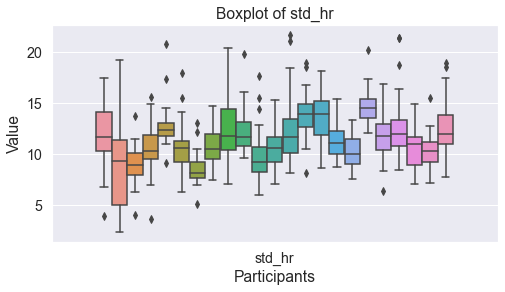

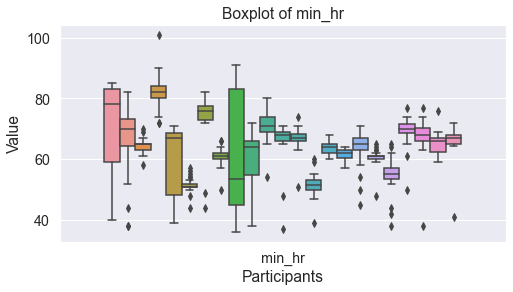

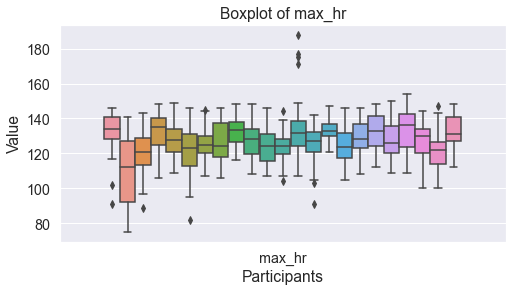

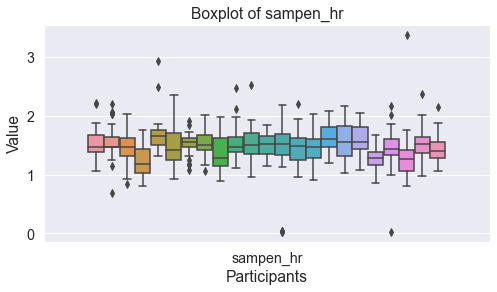

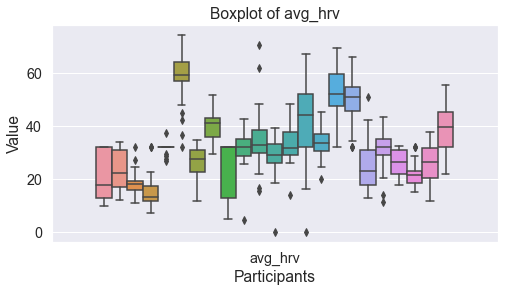

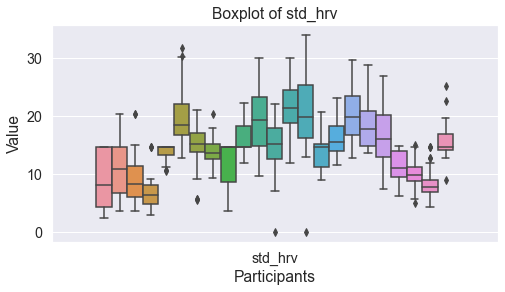

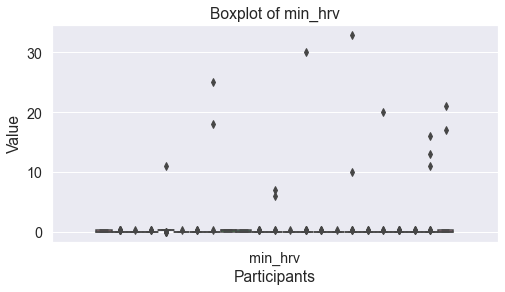

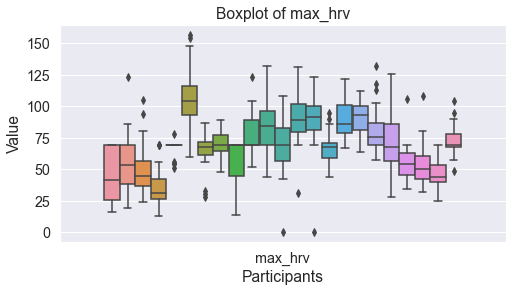

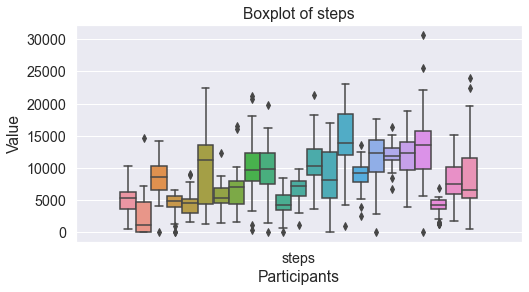

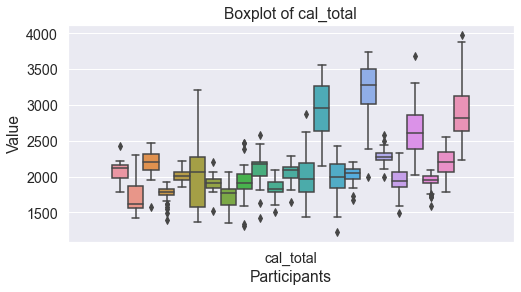

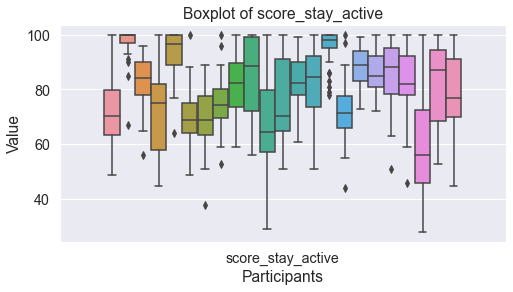

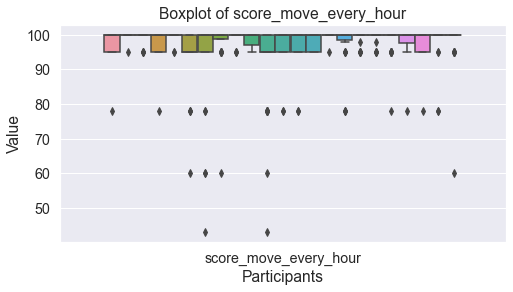

In [111]:
# Ensure 'date' is a datetime object if it's not already
oura_data['date'] = pd.to_datetime(oura_data['date'])

# Select numeric features excluding 'date_ordinal' which we will use for regression
numeric_features = oura_data.select_dtypes(include=[np.number]).columns.tolist()

# Melt the DataFrame to have feature names in one column and values in another
# Here we ensure 'date' and 'participant_id' are not in numeric_features before melting
# oura_data[numeric_features] = oura_data[numeric_features].apply(stats.zscore)
numeric_features = numeric_features
# melted_oura_data = oura_data[numeric_features].melt(id_vars=['date', 'participant_id'], var_name='feature', value_name='z-score')

# Loop over each numeric feature to create a separate boxplot
for feature in numeric_features:
    plt.figure(figsize=(8, 4))  # Set a smaller figure size for individual plots
    melted_oura_data = oura_data[["date", "participant_id"] + [feature]].melt(id_vars=['date', 'participant_id'], var_name='feature', value_name='value')
    sns.boxplot(data=melted_oura_data, x='feature', y='value', hue='participant_id')
    plt.title(f'Boxplot of {feature}')
    plt.ylabel('Value')
    plt.xlabel('Participants')
    plt.legend([],[], frameon=False)
    plt.show()
    

# # Create the boxplot
# plt.figure(figsize=(12, 8))
# sns.boxplot(data=melted_oura_data, x='feature', y='z-score', hue='participant_id')
# plt.xticks(rotation=90)  # Rotate the x labels for better readability
# plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
# plt.show()

In [98]:
oura_data[numeric_features]

,sleep_duration_minutes,efficiency,sri_score,avg_hr,std_hr,min_hr,max_hr,sampen_hr,avg_hrv,std_hrv,min_hrv,max_hrv,steps,cal_total,score_stay_active,score_move_every_hour
0,430.000000,93.000000,0.000000,90.285714,16.214271,42.000000,138.000000,1.331806,12.298851,3.974087,0.000000,24.000000,6509.0,2182.0,69.0,95.0
1,446.000000,93.000000,0.968750,92.118483,13.299488,41.000000,131.000000,1.389414,14.649351,6.542907,0.000000,39.000000,10324.0,2427.0,56.0,100.0
2,269.000000,93.000000,0.920139,100.902174,16.567174,45.000000,145.000000,1.233330,9.777778,2.415880,0.000000,16.000000,2399.0,1909.0,98.0,95.0
3,514.000000,91.000000,0.829861,96.481132,8.716958,85.000000,117.000000,2.209495,12.359223,4.292845,0.000000,26.000000,3532.0,1988.0,68.0,100.0
4,475.000000,55.000000,0.972222,98.267606,10.103658,84.000000,131.000000,1.472472,13.593750,9.850010,0.000000,42.000000,6315.0,2223.0,50.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779,506.109392,86.149477,0.890441,76.359606,8.093130,69.000000,128.000000,1.247793,32.071230,14.633235,0.356287,69.267964,1892.0,2401.0,61.0,60.0
780,506.109392,86.149477,0.890441,88.757764,10.690402,68.000000,119.000000,1.873549,32.071230,14.633235,0.356287,69.267964,13980.0,3332.0,83.0,100.0
781,506.109392,86.149477,0.890441,84.790244,13.805366,70.000000,140.000000,1.278354,32.071230,14.633235,0.356287,69.267964,4155.0,2468.0,100.0,100.0
782,506.109392,86.149477,0.890441,81.903553,13.400268,68.000000,148.000000,1.362764,32.071230,14.633235,0.356287,69.267964,5349.0,2620.0,67.0,95.0


In [124]:
mbss_data

,ID,Time Point,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,Q22,EE Total Score,EE Average,DP Total Score,DP Average Score,PA Total Score,PA Average Score,EE_Category,DP_Category,PA_Category
0,BIN01,Baseline,5.0,5.0,5.0,6.0,0.0,3.0,6.0,5.0,...,5.0,40.0,4.444444,15.0,3.0,29.0,3.625,Bad,Bad,Good
1,BIN01,Follow Up,4.0,4.0,6.0,6.0,0.0,5.0,6.0,5.0,...,5.0,40.0,4.444444,8.0,1.6,36.0,4.500,Bad,Good,Bad
2,BIN02,Baseline,2.0,2.0,3.0,1.0,0.0,0.0,1.0,1.0,...,0.0,10.0,1.111111,0.0,0.0,13.0,1.625,Good,Good,Good
3,BIN02,Follow Up,2.0,2.0,3.0,1.0,0.0,0.0,6.0,2.0,...,0.0,13.0,1.444444,1.0,0.2,39.0,4.875,Good,Good,Bad
4,BIN03,Baseline,0.0,0.0,2.0,6.0,0.0,0.0,6.0,3.0,...,0.0,8.0,0.888889,0.0,0.0,47.0,5.875,Good,Good,Bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,BIN33,Baseline,2.0,2.0,3.0,6.0,0.0,2.0,5.0,0.0,...,0.0,11.0,1.222222,0.0,0.0,43.0,5.375,Good,Good,Bad
65,BIN33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bad,Bad,Bad
66,BIN34,Baseline,3.0,3.0,3.0,3.0,3.0,0.0,6.0,3.0,...,3.0,26.0,2.888889,17.0,3.4,39.0,4.875,Good,Bad,Bad
67,BIN34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bad,Bad,Bad


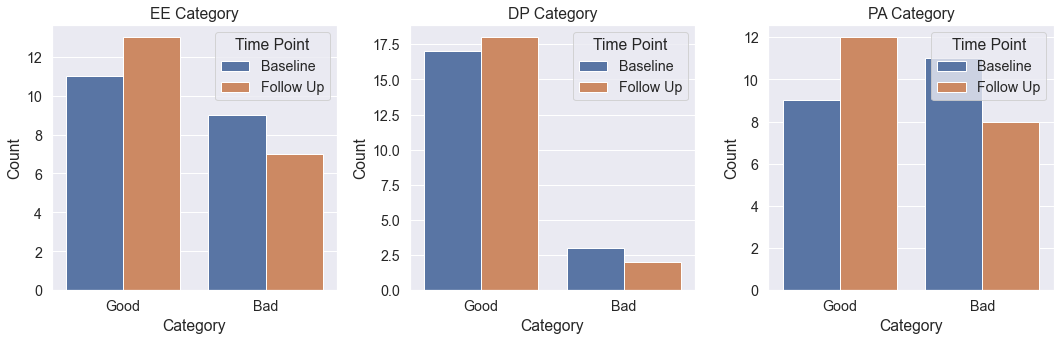

,ID,Time Point,EE_Category,DP_Category,PA_Category
0,BIN01,Baseline,Bad,Bad,Bad
1,BIN01,Follow Up,Bad,Good,Good
2,BIN02,Baseline,Good,Good,Bad
3,BIN02,Follow Up,Good,Good,Good
4,BIN03,Baseline,Good,Good,Good


In [131]:
# Define the "Good" and "Bad" thresholds for EE, DP, and PA
thresholds = {
    'EE Total Score': {'Bad': 27, 'Good': 27},
    'DP Total Score': {'Bad': 10, 'Good': 10},
    'PA Total Score': {'Bad': 33, 'Good': 33}
}

# Process data to categorize based on thresholds
def categorize(row, measure, thresholds):
    if measure == 'PA Total Score':  # For PA, higher scores are "Good"
        return 'Good' if row[measure] > thresholds[measure]['Good'] else 'Bad'
    else:  # For EE and DP, lower scores are "Good"
        return 'Good' if row[measure] < thresholds[measure]['Bad'] else 'Bad'

# Categorize the baseline and follow-up data

# Count the occurrences of each ID to find those with less than 2 entries (meaning they don't have both surveys)
participant_counts = mbss_data.dropna()['ID'].value_counts()

# Filter out participants with less than 2 entries
participants_with_followup = participant_counts[participant_counts == 2].index

# Now filter the mbss_data to only include these participants
mbss_data = mbss_data[mbss_data['ID'].isin(participants_with_followup)]
mbss_data['EE_Category'] = mbss_data.apply(lambda row: categorize(row, 'EE Total Score', thresholds), axis=1)
mbss_data['DP_Category'] = mbss_data.apply(lambda row: categorize(row, 'DP Total Score', thresholds), axis=1)
mbss_data['PA_Category'] = mbss_data.apply(lambda row: categorize(row, 'PA Total Score', thresholds), axis=1)

# Visualize the distribution of "Good" and "Bad" categories for EE, DP, and PA
plt.figure(figsize=(15, 5))
for i, measure in enumerate(['EE', 'DP', 'PA'], start=1):
    plt.subplot(1, 3, i)
    sns.countplot(data=mbss_data, x=f'{measure}_Category', order=['Good', 'Bad'], hue="Time Point")
    plt.title(f'{measure} Category')
    plt.ylabel('Count')
    plt.xlabel('Category')

plt.tight_layout()
plt.show()

# Show the first few rows of the categorized MBSS data
mbss_data[['ID', 'Time Point', 'EE_Category', 'DP_Category', 'PA_Category']].head()

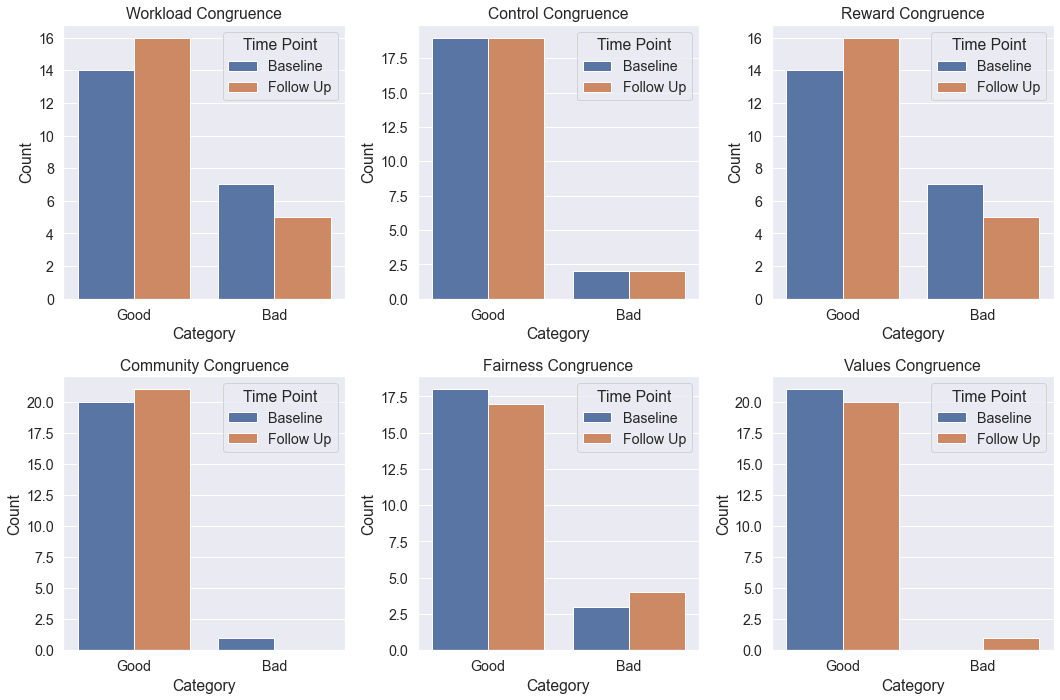

In [153]:
# Load the AWS data
gad_data = pd.read_csv('../Studies/aws_scores.csv')

# Convert all subscale scores to numeric values, assuming they are currently strings

# Define "Good" and "Bad" thresholds for AWS
aws_thresholds = {
    'subscale': 3.00  # Threshold for congruence in each sub-scale
}

# Process data to categorize based on thresholds
def categorize_aws(row, thresholds):
    categories = {}
    for col in ["Workload", "Control", "Reward", "Community", "Fairness", "Values"]:
        # Each sub-scale is evaluated for congruence
        categories[col + "_cate"] = 'Good' if row[col] >= thresholds['subscale'] else 'Bad'
    return pd.Series(categories)

# Count the occurrences of each ID to find those with less than 2 entries (meaning they don't have both surveys)
participant_counts = aws_data.dropna(subset=["Workload", "Control", "Reward", "Community", "Fairness", "Values"])['ID'].value_counts()

# Filter out participants with less than 2 entries
participants_with_followup = participant_counts[participant_counts == 2].index

# Now filter the mbss_data to only include these participants
aws_data = aws_data[aws_data['ID'].isin(participants_with_followup)]

# Filter out participants with less than 2 entries
participant_counts_aws = aws_data['ID'].value_counts()
participants_with_followup_aws = participant_counts_aws[participant_counts_aws == 2].index
aws_data_filtered = aws_data[aws_data['ID'].isin(participants_with_followup_aws)]

# Apply categorization to AWS data
aws_data_filtered = aws_data_filtered.join(aws_data_filtered.apply(lambda row: categorize_aws(row, aws_thresholds), axis=1))

# Visualize the distribution of "Good" and "Bad" categories for AWS subscales
aws_subscale_columns = ["Workload", "Control", "Reward", "Community", "Fairness", "Values"]

plt.figure(figsize=(15, 10))
for i, subscale in enumerate(aws_subscale_columns, start=1):
    plt.subplot(2, 3, i)
    sns.countplot(data=aws_data_filtered, x=subscale + "_cate", order=['Good', 'Bad'], hue='Time Point')
    plt.title(f'{subscale} Congruence')
    plt.ylabel('Count')
    plt.xlabel('Category')
plt.tight_layout()
plt.show()

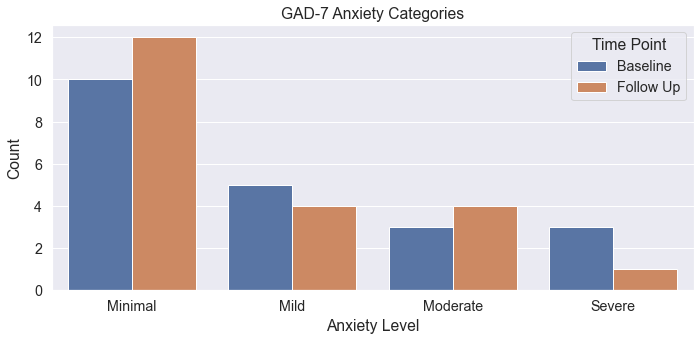

In [161]:
# Load the AWS data
gad7_data = pd.read_csv('../Studies/gad-7_scores.csv')

# Define the category thresholds for GAD-7
gad7_thresholds = {
    'Minimal': (0, 4),
    'Mild': (5, 9),
    'Moderate': (10, 14),
    'Severe': (15, 21)
}

# Function to categorize GAD-7 scores
def categorize_gad7(score):
    for category, (low, high) in gad7_thresholds.items():
        if low <= score <= high:
            return category
    return 'Unknown'  # If score does not fall into known categories


# Count the occurrences of each ID to find those with less than 2 entries (meaning they don't have both surveys)
participant_counts = gad7_data.dropna()['ID'].value_counts()

# Filter out participants with less than 2 entries
participants_with_followup = participant_counts[participant_counts == 2].index

# Now filter the mbss_data to only include these participants
gad7_data = gad7_data[gad7_data['ID'].isin(participants_with_followup)]
# Apply categorization to GAD-7 data
gad7_data['Anxiety_Category'] = gad7_data['Total Score (Items 1 - 7)'].apply(categorize_gad7)


# Count the occurrences of each ID to find those with less than 2 entries (meaning they don't have both surveys)
participant_counts_gad7 = gad7_data['ID'].value_counts()

# Filter out participants with less than 2 entries
participants_with_followup_gad7 = participant_counts_gad7[participant_counts_gad7 == 2].index

# Now filter the GAD-7 data to only include these participants
gad7_filtered = gad7_data[gad7_data['ID'].isin(participants_with_followup_gad7)]

# Visualize the distribution of anxiety categories for GAD-7
plt.figure(figsize=(10, 5))
sns.countplot(data=gad7_filtered, x='Anxiety_Category', order=['Minimal', 'Mild', 'Moderate', 'Severe'], hue='Time Point')
plt.title('GAD-7 Anxiety Categories')
plt.ylabel('Count')
plt.xlabel('Anxiety Level')
plt.legend(title='Time Point')
plt.tight_layout()
plt.show()

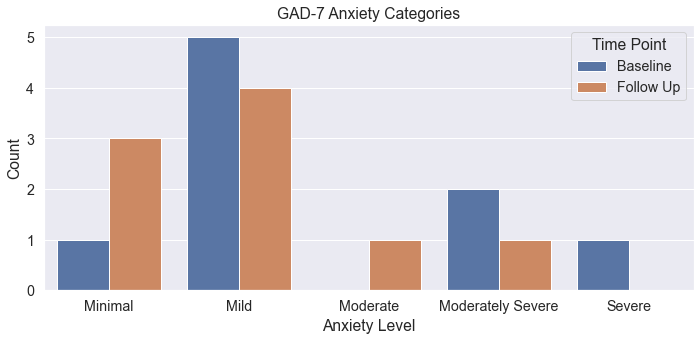

In [167]:
# Load the AWS data
phq8_data = pd.read_csv('../Studies/phq-8_scores.csv')

## Define the category thresholds for PHQ-8
phq8_thresholds = {
    'Minimal': (0, 4),
    'Mild': (5, 9),
    'Moderate': (10, 14),
    'Moderately Severe': (15, 19),
    'Severe': (20, 24)
}

# Function to categorize PHQ-8 scores
def categorize_phq8(score):
    for category, (low, high) in phq8_thresholds.items():
        if low <= score <= high:
            return category
    return 'Unknown'  # If score does not fall into known categories

# Count the occurrences of each ID to find those with less than 2 entries (meaning they don't have both surveys)
participant_counts = phq8_data.dropna()['ID'].value_counts()

# Filter out participants with less than 2 entries
participants_with_followup = participant_counts[participant_counts == 2].index

# Now filter the mbss_data to only include these participants
phq8_data = phq8_data[phq8_data['ID'].isin(participants_with_followup)]
phq8_data['Depression_Category'] = phq8_data["Total Score (Items 1 -8)"].apply(categorize_phq8)

# Count the occurrences of each ID to find those with both surveys
participant_counts_phq8 = phq8_data['ID'].value_counts()

# Filter out participants with less than 2 entries
participants_with_followup_phq8 = participant_counts_phq8[participant_counts_phq8 == 2].index

# Filter the data to include only these participants
phq8_filtered = phq8_data[phq8_data['ID'].isin(participants_with_followup_phq8)]


# Visualize the distribution of anxiety categories for GAD-7
plt.figure(figsize=(10, 5))
sns.countplot(data=phq8_filtered, x='Depression_Category', order=['Minimal', 'Mild', 'Moderate', 'Moderately Severe', 'Severe'], hue='Time Point')
plt.title('GAD-7 Anxiety Categories')
plt.ylabel('Count')
plt.xlabel('Anxiety Level')
plt.legend(title='Time Point')
plt.tight_layout()
plt.show()

In [163]:
phq8_data

,ID,Time Point,Q1 Little Interest,Q2 Feeling Down,Q3 Trouble Sleeping,Q4 Feeling Tired,Q5 Appetite Change,Q6 Feeling Bad About Yoruself,Q7 Trouble Concentrate,Q8 Move Slow/ Restless,Q10 Distress,Total Score (Items 1 -8)
0,BIN01,Baseline,2.0,2.0,3.0,3.0,1.0,2.0,2.0,0.0,3.0,15
1,BIN01,Follow Up,1.0,1.0,2.0,2.0,0.0,2.0,2.0,1.0,2.0,11
2,BIN02,Baseline,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,8
3,BIN02,Follow Up,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,5
4,BIN03,Baseline,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
64,BIN33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
65,BIN34,Baseline,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,6
66,BIN34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
67,BIN35,Baseline,0.0,0.0,1.0,1.0,2.0,0.0,2.0,0.0,NaN,6
